In [1]:
#helper functions ...
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import poisson

from cooltools.plotools import show_heatmap_wfeat, get_kernel

from cooltools.loopify import diagonal_matrix_tiling, \
                              get_adjusted_expected_tile_some_nans, \
                              multiple_test_BH, \
                              clust_2D_pixels

from bioframe import parse_humanized, parse_region_string
# from scipy.ndimage import convolve
# from scipy.linalg import toeplitz


from cooltools.snipping import LazyToeplitz

### HiCCUPS results 

We will import some of the results generated by Tyler and Houda, in order to compare our "dot"-fidner with the HiCCUPS loops-finder.

In [2]:
from copy import copy,\
                 deepcopy

def rao_to_loopify(fname,chrom,bin_size,centroid=True,color='blue',marker_size=36):
    dat = pd.read_table(fname)
    if centroid:
        ddd = copy(dat[(dat['chr1']==chrom)&(dat['chr2']==chrom)][['centroid1','centroid2']])
        ddd = ddd.rename(columns={'centroid1':'row','centroid2':'col'})
    else:
        ddd = copy(dat[(dat['chr1']==chrom)&(dat['chr2']==chrom)][['x1','y1']])
        ddd = ddd.rename(columns={'x1':'row','y1':'col'})
    ddd = ddd/bin_size
    ddd['color']=color
    ddd['marker_size']=marker_size
    # return
    return ddd

### Inputs for `call_loops_per_chrom`

Prepare a nice cooler-file, chromosome of interest, expected in `pd.DataFrame` format, and for now, just a single `kernels=[kernel, ]` to perform peak-calling against locally-adjusted expected.  

In [3]:
# cname = './houda/Houda_Ctrl_DpnII_K562.20000.cool'
# cname = './houda/Houda_Ctrl_DpnII_K562.10000.cool'
cname = './anne-laure/PTB2539-NT.20000.cool'
ename = cname.rstrip(".cool") + ".cis.expected"
the_c = cooler.Cooler(cname)
for k,v in the_c.info.items():
    print(k,v)

#chromosome of interest
chrom = "chr17"

# # Run CLI expected when needed:
# !cooltools compute_expected --contact-type cis --nproc 18 $cname > $ename
cis_exp = pd.read_table(ename,index_col=[0,1])
# # trans expected, just for the record:
# !cooltools compute_expected --contact-type trans PTB2539-NT.200000.cool > PTB2539-NT.200000.trans.expected
# trans_exp = pd.read_table("PTB2539-NT.200000.trans.expected",index_col=[0,1])

# assuming cooler, chrom and expected as input ...
ice_v_name = "weight"
exp_v_name = "balanced.avg"

# HICCUPS results loading ...
frao = "../Rao_MboI_K562_merged_loops.txt"
fhouda = "../houda_control_DpnII_K562_merged_loops.txt"

b = the_c.info['bin-size']
# drao - are loops called by Tyler on Rao2014 data K562  
drao = rao_to_loopify(frao,chrom=chrom,bin_size=b)
# dhouda - are loops called by Tyler on Houda's data K562  
dhouda = rao_to_loopify(fhouda,chrom=chrom,bin_size=b)



bin-type fixed
bin-size 20000
nchroms 25
nbins 154795
sum 1106009388
nnz 510537257
genome-assembly hg19
metadata {}
creation-date 2017-12-11T06:24:11.564370
generated-by cooler-0.7.5
format HDF5::Cooler
format-version 2
format-url https://github.com/mirnylab/cooler


### Donut mask

let's create a donut shape mask for downstream analysis ...

We're exploring 10KB Hi-C matrix in this example, but donut-mask parameters, probably must be different for 10kb, look up Rao et el. 2014.

params are not the most efficient, perhaps ...

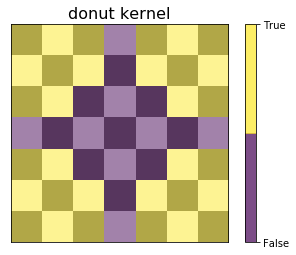

In [4]:
w = 3
p = 1
kernel = get_kernel(w,p,ktype='donut')

# kernel/kernel.sum()



## stick to diag tiling strategy

## todo:

 - combine into 1 pipeline ...


### Trying the loopify:

Let's finally try to call peaks using loopify:

In [5]:
# # import multiprocessing as mp
# nproc = len(the_c.chromnames[:-1])
# print("creating a Pool of {} workers!".format(nproc))
# p = mp.Pool(nproc)

# p.map?

#####################################
#     this used to be outside of func ...
#####################################
b = the_c.binsize
band_2Mb = 2e+6
band_idx = int(band_2Mb/b)
# w = 3
nans_tolerated = 1
tile_size = int(12e6/b)
verbosity = False
clust_radius=39000
threshold_cluster = round(clust_radius/float(b))
#####################################
#####################################


# for every chri ...
def func(chri):
    #     #####################################
    #     #     this used to be outside of func ...
    #     #####################################
    #     b = the_c.binsize
    #     band_2Mb = 2e+6
    #     band_idx = int(band_2Mb/b)
    #     # w = 3
    #     nans_tolerated = 1
    #     tile_size = int(12e6/b)
    #     verbosity = False
    #     clust_radius=39000
    #     threshold_cluster = round(clust_radius/float(b))
    #     #####################################
    #     #####################################
    chr_start,chr_stop = the_c.extent(chri)
    lazy_exp = LazyToeplitz(cis_exp.loc[chri][exp_v_name].values)
    #################################################
    # test the newest 'get_adjusted_expected_tile_some_nans'
    # using diagonal chunking here ...
    #################################################
    res_df = pd.DataFrame([])
    for tile in diagonal_matrix_tiling(chr_start, chr_stop, w, band = band_idx):
        tilei = tile
        tilej = tile
        # let's keep i,j-part explicit here:
        origin = (tilei[0], tilej[0])
        # RAW observed matrix slice:
        observed = the_c.matrix(balance=False)[slice(*tilei), slice(*tilej)]
        # expected as a tile :
        expected = lazy_exp[slice(*tilei), slice(*tilej)]
        # slice of ice_weight :
        ice_weight = the_c.bins()[slice(*tile)][ice_v_name].values
        # that's the main working function from loopify:
        res = get_adjusted_expected_tile_some_nans(origin = origin,
                                                 observed = observed,
                                                 expected = expected,
                                                 bal_weight = ice_weight,
                                                 kernels = {"donut":kernel,},
                                                 verbose = verbosity)
        # post-processing filters now reside outside of get_la_exp:
        is_inside_band = (res["bin1_id"]>(res["bin2_id"]-band_idx))
        # departure from the tests - count NaNs in donut, not footprint ...
        does_comply_nans = (res["la_exp."+"donut"+".nnans"] < nans_tolerated)
        # so, selecting inside band and nNaNs compliant results:
        res_df = res_df.append(
                    res[is_inside_band & does_comply_nans],
                    ignore_index=True)
    # drop dups and reset index:
    res_df = res_df.drop_duplicates().reset_index(drop=True)
    #
    # move Poisson tests here :
    res_df["la_exp."+"donut"+".pval"] = 1.0 - \
            poisson.cdf(res_df["obs.raw"],
                        res_df["la_exp."+"donut"+".value"])
    # perform multiple-hypoth testing for each chri
    alpha=0.02
    res_df['rej_null'], _ = multiple_test_BH(
                                    res_df["la_exp."+"donut"+".pval"],
                                    alpha=alpha)
    # 
    #
    # 
    # Next step is clustering of the data:
    # cluster em' using the threshold:
    peaks_clust = clust_2D_pixels(
                        res_df[res_df['rej_null']],
                        threshold_cluster=threshold_cluster)
    # and merge (index-wise) with the main DataFrame:
    res_df =  res_df.merge(
                    peaks_clust,
                    how='left',
                    left_index=True,
                    right_index=True)
    #
    return res_df
#     print("chrom {} processing is complete".format(chri))




In [10]:
# %%time
# import multiprocessing as mp
nproc = len(the_c.chromnames[:-1])
print("creating a Pool of {} workers!".format(nproc))
with mp.Pool(nproc) as p:
    rrrr = p.map(func, list(the_c.chromnames[:-1]))
    

# # p.map?

# # p.map?
# p.close()

# p.join()

# # # %%time
# # pixel_info_Pool = dict(
# #                     zip(
# #                         the_c.chromnames[:-1],
# #                         p.map(func, the_c.chromnames[:-1])
# #                         )
# #                        )

creating a Pool of 24 workers!
matrix of size 4060X4060 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 40  Non-edge case size of each tile is 206X206
matrix of size 5127X5127 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 51  Non-edge case size of each tile is 206X206matrix of size 9046X9046 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 90  Non-edge case size of each tile is 206X206matrix of size 7957X7957 to be splitted s

/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))


matrix of size 2566X2566 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 25  Non-edge case size of each tile is 206X206matrix of size 2957X2957 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 29  Non-edge case size of each tile is 206X206matrix of size 3152X3152 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 31  Non-edge case size of each tile is 206X206matrix of size 7764X7764 to be splitted so that
  diagonal region of size

/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))
/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: Ru

Some significant peaks have been detected!
pval border is between 0.0163 and 0.0197


/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))


Clustering is completed:
there are 313 clusters detected
mean size 13.881789+/-6.197657
labels and centroids to be reported.
Some significant peaks have been detected!
pval border is between 0.0000 and 0.0000
Some significant peaks have been detected!
pval border is between 0.0002 and 0.0002
Clustering is completed:
there are 140 clusters detected
mean size 2.042857+/-1.638254
labels and centroids to be reported.
Clustering is completed:
there are 544 clusters detected
mean size 2.755515+/-2.541018
labels and centroids to be reported.
Some significant peaks have been detected!
pval border is between 0.0002 and 0.0002
Clustering is completed:
there are 694 clusters detected
mean size 2.332853+/-2.086774
labels and centroids to be reported.
Some significant peaks have been detected!
pval border is between 0.0002 and 0.0002
Clustering is completed:
there are 778 clusters detected
mean size 2.763496+/-2.560949
labels and centroids to be reported.
Some significant peaks have been detected!


In [17]:
%%time
b = the_c.binsize
band_2Mb = 2e+6
band_idx = int(band_2Mb/b)
# w = 3
nans_tolerated = 1
tile_size = int(12e6/b)
verbosity = False
clust_radius=39000
threshold_cluster = round(clust_radius/float(b))

pixel_info = {}
for chri in the_c.chromnames[:-1]:
    chr_start,chr_stop = the_c.extent(chri)
    lazy_exp = LazyToeplitz(cis_exp.loc[chri][exp_v_name].values)

    #################################################
    # test the newest 'get_adjusted_expected_tile_some_nans'
    # using diagonal chunking here ...
    #################################################
    res_df = pd.DataFrame([])
    for tile in diagonal_matrix_tiling(chr_start, chr_stop, w, band = band_idx):
        tilei = tile
        tilej = tile
        # let's keep i,j-part explicit here:
        origin = (tilei[0], tilej[0])
        # RAW observed matrix slice:
        observed = the_c.matrix(balance=False)[slice(*tilei), slice(*tilej)]
        # expected as a tile :
        expected = lazy_exp[slice(*tilei), slice(*tilej)]
        # slice of ice_weight :
        ice_weight = the_c.bins()[slice(*tile)][ice_v_name].values
        # that's the main working function from loopify:
        res = get_adjusted_expected_tile_some_nans(origin = origin,
                                                 observed = observed,
                                                 expected = expected,
                                                 bal_weight = ice_weight,
                                                 kernels = {"donut":kernel,},
                                                 verbose = verbosity)
        # post-processing filters now reside outside of get_la_exp:
        is_inside_band = (res["bin1_id"]>(res["bin2_id"]-band_idx))
        # departure from the tests - count NaNs in donut, not footprint ...
        does_comply_nans = (res["la_exp."+"donut"+".nnans"] < nans_tolerated)
        # so, selecting inside band and nNaNs compliant results:
        res_df = res_df.append(
                    res[is_inside_band & does_comply_nans],
                    ignore_index=True)
    # drop dups and reset index:
    res_df = res_df.drop_duplicates().reset_index(drop=True)
    #
    # move Poisson tests here :
    res_df["la_exp."+"donut"+".pval"] = 1.0 - \
            poisson.cdf(res_df["obs.raw"],
                        res_df["la_exp."+"donut"+".value"])
    # adjust the origin :
    # res_df['row'] = res_df['row'] - chr_start
    # res_df['col'] = res_df['col'] - chr_start
    #     
    # perform multiple-hypoth testing for each chri
    # right on spot:
    # PER CHROM ACTION(? check Rao et al):
    # cannot do it on kernel level, as it
    # is tiled at that point ...
    alpha=0.02
    # alpaha could vary for different kernels ...
    # alpha=0.1
    res_df['rej_null'], _ = multiple_test_BH(
                                    res_df["la_exp."+"donut"+".pval"],
                                    alpha=alpha)
    # 
    #
    # 
    # Next step is clustering of the data:
    ###############
    # clustering starts here:
    # http://scikit-learn.org/stable/modules/clustering.html
    # picked Birch, as the most appropriate here:
    ###############
    # cluster em' using the threshold:
    peaks_clust = clust_2D_pixels(
                        res_df[res_df['rej_null']],
                        threshold_cluster=threshold_cluster)
    # and merge (index-wise) with the main DataFrame:
    res_df =  res_df.merge(
                    peaks_clust,
                    how='left',
                    left_index=True,
                    right_index=True)
    #
    #
    # save using a distinct name:
    pixel_info[chri] = res_df
    #
    print("chrom {} processing is complete".format(chri))



matrix of size 12463X12463 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 124  Non-edge case size of each tile is 206X206


/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:651: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))


Some significant peaks have been detected!
pval border is between 0.0002 and 0.0002
Clustering is completed:
there are 2779 clusters detected
mean size 2.657071+/-2.354984
labels and centroids to be reported.
chrom chr1 processing is complete
matrix of size 12160X12160 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 121  Non-edge case size of each tile is 206X206
Some significant peaks have been detected!
pval border is between 0.0001 and 0.0001
Clustering is completed:
there are 2568 clusters detected
mean size 2.528427+/-2.306864
labels and centroids to be reported.
chrom chr2 processing is complete
matrix of size 9902X9902 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull 

Some significant peaks have been detected!
pval border is between 0.0001 and 0.0001
Clustering is completed:
there are 356 clusters detected
mean size 2.078652+/-1.717227
labels and centroids to be reported.
chrom chr16 processing is complete
matrix of size 4060X4060 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 40  Non-edge case size of each tile is 206X206
Some significant peaks have been detected!
pval border is between 0.0002 and 0.0002
Clustering is completed:
there are 1034 clusters detected
mean size 2.801741+/-2.637396
labels and centroids to be reported.
chrom chr17 processing is complete
matrix of size 3904X3904 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull co

## TODO:

 - replace pixel_info dict with a huge DataFrame
 - perform cooler.annotate on the entire pixel_info DataFrame (BEDPE-like) ...
 - see, if stuff like that should be done with filtering [rej_null] ?!(5kb will be scary ...)
 - come up with plotting tools that understand BEDPE - i.e. chrom, start, end - stuff
 - update other notebook ...
 - metric of pixel closeness in a BEDPE format - i.e. chrom, start, end (lookup in HiPiler) ...

## start filtering out peaks DataFrame and deal with p-values

### todo:
 - update the `get_adjusted_expected_tile_some_nans` interface, i.e. what's the output? which columns to include? etc.?
 - any extra filtering steps, depending on the output of the `get_adjusted_expected_tile_some_nans`?
 - upper triangle decision ?! do `get_adjusted_expected_tile_some_nans` return upper triangle contacts only? or full thing?
 - `NaN_mask` to be used as a mask or should we return `number_of_nans` for each pixel's vicinity ?


In [12]:
# dots to compare ...
dots = pd.concat(( pixel_info[chri][pixel_info[chri]['rej_null']] for chri in the_c.chromnames[:-1] ))
dots_Pool = pd.concat(( rrr[rrr['rej_null']] for rrr,chri in zip(rrrr,the_c.chromnames[:-1]) ))

In [16]:
(dots == dots_Pool).all()

bin1_id               True
bin2_id               True
la_exp.donut.value    True
la_exp.donut.nnans    True
exp.raw               True
obs.raw               True
la_exp.donut.pval     True
rej_null              True
cbin1_id              True
cbin2_id              True
c_label               True
c_size                True
dtype: bool

In [14]:
dots_Pool.head()

,bin1_id,bin2_id,la_exp.donut.value,la_exp.donut.nnans,exp.raw,obs.raw,la_exp.donut.pval,rej_null,cbin1_id,cbin2_id,c_label,c_size
165,43,62,88.132672,0,44.019438,125,8.622993e-05,True,45.076923,61.615385,0.0,11.0
166,43,63,67.370764,0,34.489341,108,1.940658e-06,True,45.076923,61.615385,0.0,11.0
240,44,61,65.258294,0,31.521203,113,3.017919e-08,True,45.076923,61.615385,0.0,11.0
241,44,62,105.092662,0,51.836615,184,1.237010e-12,True,45.076923,61.615385,0.0,11.0
242,44,63,81.000719,0,40.452571,128,5.440388e-07,True,45.076923,61.615385,0.0,11.0


In [ ]:
# let's try to annotate an entire dictionary 'pixel_info',
# every pixel that was accepted ...
dots = pd.concat((
        cooler.annotate(
            pixel_info[chri][pixel_info[chri]['rej_null']],
            the_c.bins()[:]) \
        for chri in the_c.chromnames[:-1]
        )) 


In [ ]:
dots[['chrom1','start1','end1','chrom2','start2','end2','c_size']].to_csv(
                                                                    "PTB2539-NT.dots.bedpe.gz",
                                                                    sep='\t',
                                                                    header=False,
                                                                    index=False,
                                                                    compression='gzip')

In [ ]:
# chrom = "chr17"
peaks_local = pixel_info[chrom]
M_ice = the_c.matrix().fetch(chrom)


In [ ]:
# cooler.annotate?
# cooler.annotate(pixels, bins, replace=True)
#     A data frame containing columns named ``bin1_id`` and/or ``bin2_id``.
#     If columns ``bin1_id`` and ``bin2_id`` are both present in ``pixels``,
#     the adjoined columns will be suffixed with '1' and '2' accordingly.
    
cooler.annotate( peaks_local.rename(columns={"row":"bin1_id","col":"bin2_id"}), the_c.bins()[:] ).head()


# peaks_local.rename(mapper=None, index=None, columns=None, axis=None, copy=True, inplace=False, level=None)

In [ ]:
# total # of non-singleton peaks called :
len(peaks_local[peaks_local['rej_null']&(peaks_local['c_size']>1)]['c_label'].drop_duplicates())

In [ ]:
# we need to color some pixels 
# new_peaks[new_peaks['rej_null']]

peaks_local['color'] = peaks_local['c_size'].apply(lambda x: 'blue' if x>1 else 'skyblue')

In [ ]:


# test the functions from plotools.py:

# regions of interest
# looprich in HEP and loop-poor in K562
# "chr17:8,000,000-14,000,000"
# looprich in K562 and loop-poor in HEP
# "chr17:46,000,000-50,000,000"

# "chr8:101,000,000-104,000,000"

region_of_interest = "chr17:8,000,000-14,000,000"


h_range = [int(_/b)
             for _ in parse_region_string(region_of_interest)
               if isinstance(_,int)]
v_range = h_range

# # mmm = combine_matrix_tris(M_ice, np.multiply(E_raw, np.outer(v_ice,v_ice)))
ax = show_heatmap_wfeat(np.log10(M_ice),
                   h_range,
                   v_range,
                   feature_df=peaks_local[peaks_local['rej_null']],
                   b=b,
                   show_bad=True,
                   figsize=(22, 22),
                   ax=None,
                   bad_color='white',
                   vmin=None,
                   vmax=None,
                   heat_type='log10')



# ax.plot(
#     [parse_humanized('8.0M'),parse_humanized('10.52M')],
#     [parse_humanized('10.52M'),parse_humanized('10.52M')])


# ax.plot(
#     [parse_humanized('9.32M'),parse_humanized('10.52M')],
#     [parse_humanized('10.52M'),parse_humanized('10.52M')],color='green',lw=5)


In [ ]:
show_heatmap_wfeat(np.log10(M_ice),
                   h_range,
                   v_range,
                   feature_df=drao,
                   b=b,
                   show_bad=True,
                   figsize=(22, 22),
                   ax=None,
                   bad_color='white',
                   vmin=None,
                   vmax=None,
                   heat_type='log10')

In [ ]:
drao

## Vicinity of a pixel

simply plot a small vicinity of the pixel as a heatmap 

In [ ]:
# print(bioframe.parse_humanized('102.345M'))

# # # peak pixel:
# col = 491
# row = 525


# col,row = drao[(drao['row']*b/1000000>101.6)&(drao['row']*b/1000000<104)][['row','col']].iloc[2]

# print(col*b/1000000)
# print(row*b/1000000)

# # col = 538
# # row = 592

# # vmin = -4.26018010407
# # vmax = -0.900413109695

# # h_range = (400,720)
# # v_range = (400,720)

# # h_range = (435,480)
# # v_range = (435,480)

# # h_range=(2260,2520)
# # v_range=(2260,2520)



# show_heatmap_pixel(np.log10(M_ice),
#                    col=int(col),
#                    row=int(row),
#                    win=5,
#                    ax=None,
#                    vmin=None,
#                    vmax=None,
#                    ax_visible=False)

In [ ]:

# ############
# # next, we should check if
# # using peaks_df['pval'] with NaNs
# # and etc. yields the same results
# # as excluding NaNs etc from array ...
# ############
# if peaks['pval'].isnull().any():
#     print("There are NaNs among pvals ... #SAD")
    
# # for fun ...
# _,bins,_ = plt.hist(peaks['pval'],
#                     log=True,
#                     bins=np.logspace(-9,0,50),
#                     label="all")   
# ax = plt.gca()
# ###############
# # do multiple-hyp-testing
# ###############
# rejnull, pvr = loopify.multiple_test_BH(peaks['pval'], alpha=0.02)

# print("percent of Null hypothesis rejected {}".format(rejnull.sum()/rejnull.size*100.0))

# ############
# # show pvals with Null rejected ...
# ############
# ax.hist(peaks[rejnull]['pval'],
#         log=True,
#         bins=bins,
#         color='red',
#         label="not_null")

# ax.set_xscale("log")
# ax.set_xlabel("p-value")
# ax.legend()

In [ ]:
# # peak pixel:
# # 491,
# # 525,

# 538,
# 592,



pos = int(parse_humanized('10.52M')/b)

dpos = int(parse_humanized('1.5M')/b)

plt.plot(np.log10(M_ice[pos:pos+dpos,pos]),label="OBS",lw=2)


k = np.array([1,1,1,1,0,1,1,1,1])
ccc = np.convolve(M_ice[pos:pos+dpos,pos],k/k.sum(),mode='same')
cex = np.convolve(E_ice[pos:pos+dpos,pos],k/k.sum(),mode='same')

plt.plot(np.log10(ccc[:dpos]),label="LOC",lw=5)
# plt.plot(np.log10(E_ice[pos:pos+dpos,pos]*ccc[:dpos]/cex[:dpos]))

# plt.plot(np.log10(cex[:100]))
import matplotlib.ticker as ticker

# plt.plot(np.log10(E_ice[pos:pos+dpos,pos]),lw=5,label="EXP")

plt.legend(fontsize=16)

f = plt.gcf()
ax = plt.gca()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: x*b/1000000))
ax.set_xlabel("distance from diagonal, M",fontsize=16)
ax.set_ylabel("log10(relative contact frequency)",fontsize=16)

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 

# print(ax.get_xlim())
# print(ax.get_ylim())

ax.set_xlim((-3.7000000000000002, 77.700000000000003))
ax.set_ylim((-3.1352748720026811, -1.1114994123986353))

f.set_size_inches(14,10)

#plt.plot(np.log10(M_ice[500,500:500+100]))